In [1]:
import pytorch_lightning as pl
import yaml
from Models.ldm import AutoencoderKL
import torch
import matplotlib.pyplot as plt
from einops import rearrange
from functools import partial
import einops
from torch.nn import functional as F

In [2]:
pl.seed_everything(42, workers=True)

Seed set to 42


42

In [3]:
model_ckpt = "/Users/balazsmorvay/Downloads/epoch=51-step=75500.ckpt"
with open(r"../Configurations/ABIDE/vae_config.yml", 'r+') as yaml_file:
    pipeline_cfg = yaml.safe_load(yaml_file)

In [4]:
model = AutoencoderKL(**pipeline_cfg)
vae_ckpt = torch.load(model_ckpt, map_location='cpu')
model.load_state_dict(vae_ckpt['state_dict'])
decoder = model.decoder.to(device='mps').eval()

making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
Working with z of shape (1, 4, 16, 16) = 1024 dimensions.
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels


In [5]:
with torch.inference_mode():
    inp = torch.randn(size=(8, 4, 16, 16)).to('mps') # 8 * latent_dim
    out = decoder(inp)
    print(out.shape)

torch.Size([8, 61, 67, 65])


<Figure size 640x480 with 0 Axes>

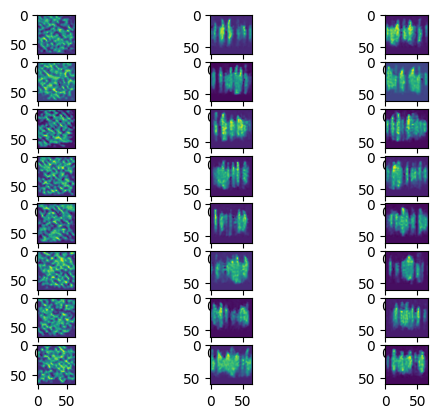

In [6]:
plt.figure()

f, axarr = plt.subplots(8, 3)
for ind, image in enumerate(out.to('cpu')):
    axarr[ind, 0].imshow(image[20, ...]) # w * d
    axarr[ind, 1].imshow(rearrange(image, 'h w d -> w h d')[20]) # h * d
    axarr[ind, 2].imshow(image[..., 20]) # h * w

In [7]:
from Data.dataloaders import ABIDELoader

transforms = {
    'fmri': [
        partial(einops.rearrange, pattern='b h l d -> b d h l'),
        partial(F.pad, pad=(0, 0, 3, 3))
    ]
}

datahandler = ABIDELoader(
    root_dir=r"/Users/balazsmorvay/Downloads/ABIDE/data/Outputs/ccs/filt_noglobal/func_preproc",
    exp_path=r"../Configurations/ABIDE",
    transforms=transforms,
    batch_size=1,
    num_workers=12,
    prefetch_factor=2,
    persistent_workers=True
)

datahandler.setup(stage='test')

In [8]:
batch = next(iter(datahandler.test_dataloader()))
image = batch['fmri']
image.shape

/Users/balazsmorvay/anaconda3/envs/VAE/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_5ae0635zuj/croot/pytorch-select_1700511177724/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/Users/balazsmorvay/anaconda3/envs/VAE/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You

torch.Size([1, 61, 73, 61])

<Figure size 640x480 with 0 Axes>

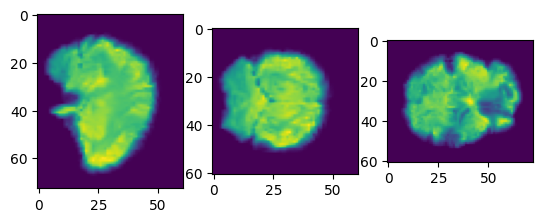

In [9]:
plt.figure()
im = image[0]
f, axarr = plt.subplots(1,3) 
axarr[0].imshow(im[20, ...]) # w * d
axarr[1].imshow(rearrange(im, 'h w d -> w h d')[20]) # h * d
axarr[2].imshow(im[..., 20]) # h * w

In [10]:
model = model.to('mps').eval()
with torch.inference_mode():
    image = image.to('mps')
    outp = model(image)
outp[0].shape

torch.Size([1, 61, 75, 61])

torch.Size([61, 75, 61])


<Figure size 640x480 with 0 Axes>

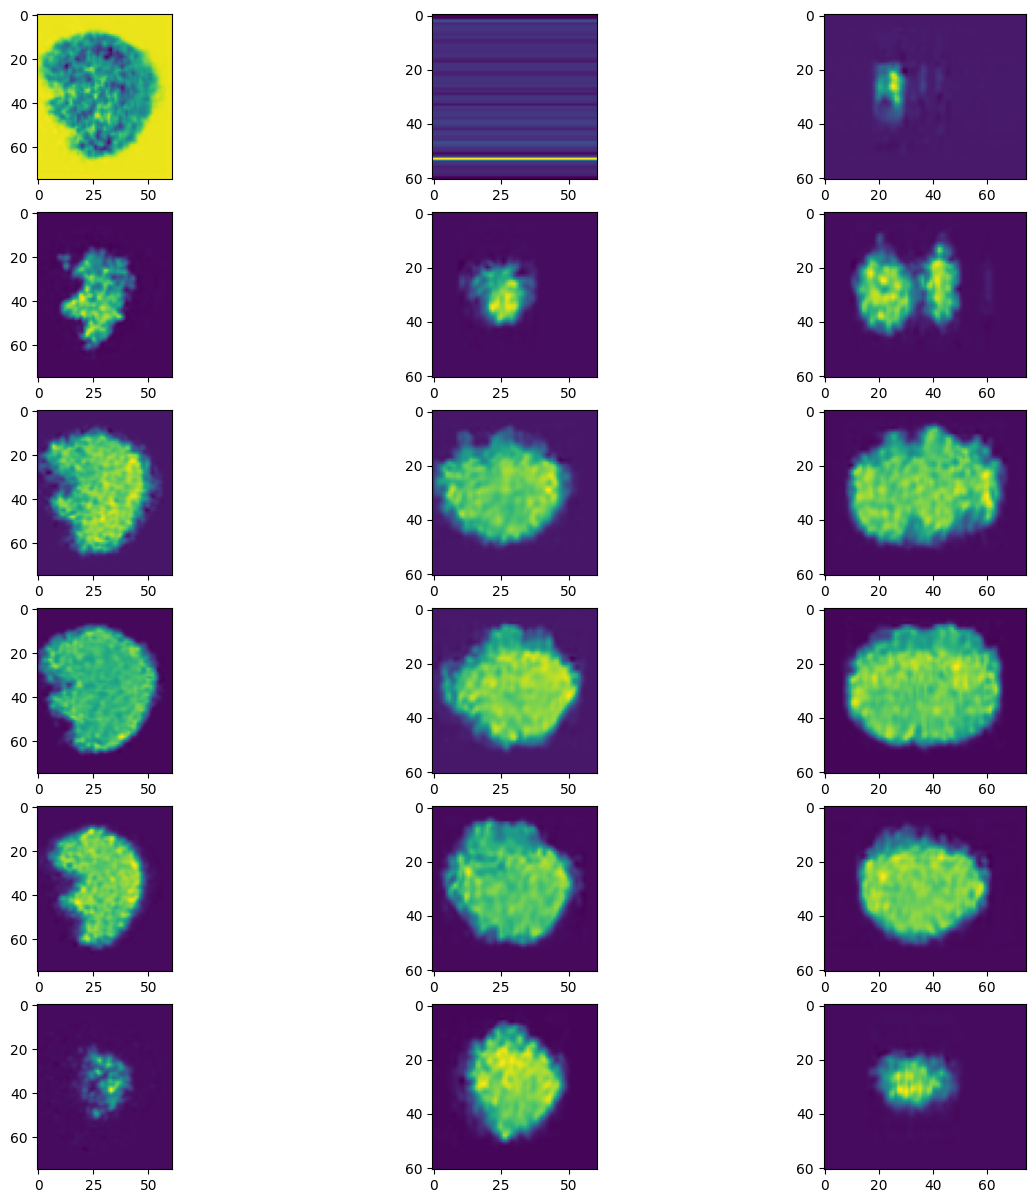

In [11]:
plt.figure()
im = outp[0].to('cpu')
im = im.squeeze()
print(im.shape)
f, axarr = plt.subplots(6, 3, figsize=(15, 15))
for ind in range(6):
    axarr[ind, 0].imshow(im[ind*10, ...]) # w * d
    axarr[ind, 1].imshow(rearrange(im, 'h w d -> w h d')[ind*10]) # h * d
    axarr[ind, 2].imshow(im[..., ind*10]) # h * w


<Figure size 640x480 with 0 Axes>

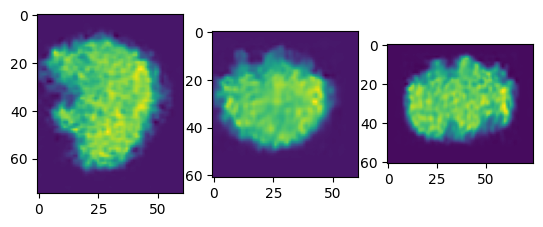

In [12]:
plt.figure()
f, axarr = plt.subplots(1,3) 
axarr[0].imshow(im[20, ...]) # w * d
axarr[1].imshow(rearrange(im, 'h w d -> w h d')[20]) # h * d
axarr[2].imshow(im[..., 20]) # h * w